In [1]:
# Initialize the notebook
using Pkg
Pkg.activate("..")
#include("../src/Particles.jl")
using Particles
using Plots
using Zarr
using ZipFile

nothing

  Activating project at `d:\Projects\particles.jl`


In [16]:
# unzip the flow data (if not already done)

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

if !isdir("./ZUNORMM_map_fullgrid_v2.zarr") 
    unzip("./ZUNORMM_map_fullgrid_v2.zip","")
end


In [17]:
Zarr_data = ZarrData(".","ZUNORMM_map_fullgrid_v2.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
v=initialize_interpolation(Zarr_data,"y_velocity",t0)
s=initialize_interpolation(Zarr_data,"salinity",t0)

nothing

In [18]:
z0=Zarr_data.file.arrays["waterdepth"]



ZArray{Int16} of size 999 x 499 x 181

In [19]:
z0=Zarr_data.file.arrays["waterlevel"]


ZArray{Int16} of size 999 x 499 x 181

In [20]:
z0=Zarr_data.file.arrays["x_velocity"]


ZArray{Int16} of size 999 x 499 x 46 x 181

In [ ]:
z0=Zarr_data.file.arrays["z_iface_3d"]


In [21]:
# find the extent of the data
xy_bbox=Zarr_data.xy_grid.bbox
println("bbox=$(xy_bbox)") #bbox=[3.4773802907221345, 5.566420993890162, 51.66065856527758, 52.466444933890344]

z0=Zarr_data.file.arrays["waterdepth"]
z0_scaled=0.01*z0
println("min=",minimum(z0_scaled),"max=",maximum(z0_scaled))

z0=Zarr_data.file.arrays["waterlevel"]
z0_scaled=0.01*z0
println("min=",minimum(z0_scaled),"max=",maximum(z0_scaled))



t=Zarr_data.file.arrays["time"][:] #"seconds since 2022-04-01 00:00:00 +00:00"
println(t0) #"seconds since 2022-04-16 00:00:00 +00:00"
println( (t[2]-t[1])/3600.0 ) #2022-04-16 step=2hrs until 2022-05-01
println( (t[end]-t[2])/3600.0/24.0) #2022-04-16 duraton~=15hrs until 2022-05-01

Zarr_data.file.arrays["salinity"].attrs

bbox=[3.4773802907221345, 5.566420993890162, 51.66065856527758, 52.466444933890344]
min=0.0max=99.99000000000001


min=-1.53max=99.99000000000001
2022-04-16T00:00:00
2.0
14.916666666666666


Dict{String, Any} with 12 entries:
  "cell_methods"      => "mesh2d_nFaces: mean"
  "long_name"         => "Salinity in flow element"
  "scale_factor"      => 0.01
  "location"          => "face"
  "add_offset"        => 0.0
  "standard_name"     => "sea_water_salinity"
  "coordinates"       => "time z_center y_center x_center"
  "mesh"              => "mesh2d"
  "_FillValue"        => 9999
  "units"             => "1e-3"
  "_ARRAY_DIMENSIONS" => Any["time", "z", "y", "x"]
  "grid_mapping"      => "wgs84"

In [22]:
Zarr_data.file.arrays["waterdepth"].attrs

Dict{String, Any} with 13 entries:
  "cell_methods"      => "mesh2d_nFaces: mean"
  "long_name"         => "Water depth at pressure points"
  "scale_factor"      => 0.01
  "location"          => "face"
  "add_offset"        => 0.0
  "standard_name"     => "sea_floor_depth_below_sea_surface"
  "coordinates"       => "time y_center x_center"
  "cell_measures"     => "area: mesh2d_flowelem_ba"
  "mesh"              => "mesh2d"
  "_FillValue"        => 9999
  "units"             => "m"
  "_ARRAY_DIMENSIONS" => Any["time", "y", "x"]
  "grid_mapping"      => "wgs84"

In [23]:
Zarr_data.file.arrays["waterlevel"].attrs

Dict{String, Any} with 13 entries:
  "cell_methods"      => "mesh2d_nFaces: mean"
  "long_name"         => "Water level"
  "scale_factor"      => 0.01
  "location"          => "face"
  "add_offset"        => 0.0
  "standard_name"     => "sea_surface_height"
  "coordinates"       => "time y_center x_center"
  "cell_measures"     => "area: mesh2d_flowelem_ba"
  "mesh"              => "mesh2d"
  "_FillValue"        => 9999
  "units"             => "m"
  "_ARRAY_DIMENSIONS" => Any["time", "y", "x"]
  "grid_mapping"      => "wgs84"

In [24]:
x_left = 3.4
x_right = 5.6
y_bot = 51.6
y_top = 52.5
z_surface = 0.0
z_bottom = -40.0
t_start=0.0
t_step=3600.0
#t_stop=15*24*3600.0 # end of dataset at 15 days
t_stop=3*3600.0 # 12 hours

# This is using the interpolation functions instead of plotting the data directly, which is much faster.
# anim = @animate for t in range(t_start, stop = t_stop, step = t_step)
#     if t%1200==0 print("t=$(t) ") end
#     # grid for plotting only
#     x_points = range(x_left,stop=x_right,length=100) #only show 100 points in x
#     y_points = range(y_bot,stop=y_top,length=100)
#     z        = -2.0
#     #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
#     h_interp = [h(x,y,z,t) for x in x_points, y in y_points] # water level
#     s_interp = [s(x,y,z,t) for x in x_points, y in y_points] # salinity

#     l = @layout([a; b])
#     p1=heatmap(x_points,y_points,h_interp',xlabel="x",ylabel="y",title="waterlevel=$(t)",clims=(-1.5,1.5))
#     p2=heatmap(x_points,y_points,s_interp',xlabel="x",ylabel="y",title="salinity",clims=(0,35))
#     plot(p1,p2,layout=l,size=(800,400))
# end

# gif(anim, "./rmm.gif", fps = 3)


10800.0

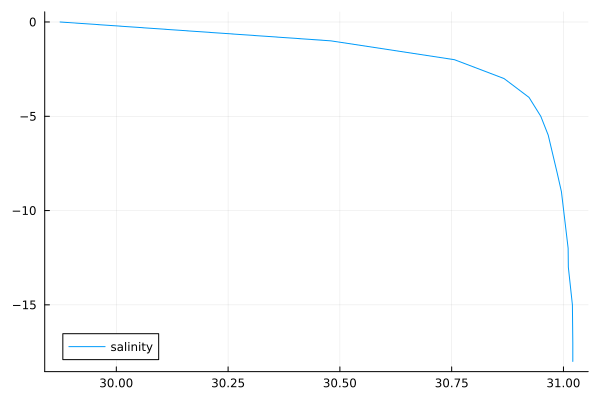

In [25]:
# plot a profile 
xp=4.0
yp=52.0
tp=2*3600.0
z_points=collect(-18.0:1.0:0.0)
s_profile = [s(xp,yp,z,tp) for z in z_points] # salinity

plot(s_profile,z_points,label="salinity")

In [26]:
x=Zarr_data.file.arrays["x_center"][:]
y=Zarr_data.file.arrays["y_center"][:]

# direct plot of surface salinity at first time step - faster and nicer
anim = @animate for t in range(1, stop = 31, step = 3)
    s0=Zarr_data.file.arrays["salinity"][:,:,46,t] #999 x 499 x 46 x 181
    s0_scaled=0.01*s0
    s0_scaled[s0 .> 9990].=NaN
    heatmap!(x,y,s0_scaled',aspect_ratio=:equal,clim=(0,40),color=:viridis)
end
gif(anim, "./temp/surface_salinity.gif", fps = 3)


In [ ]:
# direct plot of surface salinity at first time step - faster and nicer

h0=Zarr_data.file.arrays["waterlevel"] #999 x 499 x 46 x 181
# s0_scaled=0.01*s0
# s0_scaled[s0 .> 9990].=NaN
# x=Zarr_data.file.arrays["x_center"][:]
# y=Zarr_data.file.arrays["y_center"][:]

# heatmap(x,y,s0_scaled',aspect_ratio=:equal,clim=(0,40),color=:viridis)